In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
# Đường dẫn đến các tập dữ liệu
usd_data_path = '/content/drive/MyDrive/dataset/US Dollar Index Futures Historical Data.csv'
bitcoin_data_path = '/content/drive/MyDrive/dataset/Bitcoin Historical Data.csv'
nasdaq_data_path = '/content/drive/MyDrive/dataset/NASDAQ Composite Historical Data.csv'

In [118]:
# Define a function to preprocess each dataset
def preprocess_data(data_path, date_format='%d/%m/%Y'):
  df = pd.read_csv(data_path)
  df = df[::-1] # Reverse the order
  df.fillna(method='ffill', inplace=True)
  df['Price'] = df['Price'].str.replace(',', '').astype(float)
  df['Date'] = pd.to_datetime(df['Date'], format=date_format)
  return df

In [119]:
# Define a function to preprocess each dataset
def preprocess_us_data(data_path, date_format='%m/%d/%Y'):
    df = pd.read_csv(data_path)
    df = df[::-1]  # Reverse the order
    df.fillna(method='ffill', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    return df

In [120]:
# Preprocess each dataset
bitcoin_df = preprocess_data(bitcoin_data_path)
nasdaq_df = preprocess_data(nasdaq_data_path)
usd_df = preprocess_us_data(usd_data_path)

In [121]:
# Function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [122]:
def forecast_future(model, data, steps, scaler, sequence_length=30):
    last_sequence = data[-sequence_length:].reshape(1, sequence_length, 1)
    forecast = []
    for _ in range(steps):
        prediction = model.predict(last_sequence)
        forecast.append(prediction[0, 0])
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1, 0] = prediction[0, 0]

    forecast = np.array(forecast)
    forecast = forecast.reshape(-1, 1)
    forecast_prices = scaler.inverse_transform(np.hstack((forecast, np.zeros((forecast.shape[0], data.shape[1]-1)))))[:, 0]
    return forecast_prices[:steps]

In [123]:
# Function to split data into training and testing sets
def split_data(X, y, ratio):
    train_size = int(len(X) * ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

In [124]:
# Function to build the LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    return model

In [125]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, mape, rmse

In [126]:
def process_dataset(df, dataset_name):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Price']])
    sequence_length = 30
    X, y = create_sequences(scaled_data, sequence_length)
    X_train, X_test, y_train, y_test = split_data(X, y, 0.8)

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_model(input_shape)
    model.fit(X_train, y_train, epochs=1, batch_size=64, validation_split=0.1, verbose=1)

    y_pred = model.predict(X_test)
    mae, mape, rmse = evaluate_model(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred))

    forecast_30 = forecast_future(model, scaled_data, 30, scaler)
    forecast_60 = forecast_future(model, scaled_data, 60, scaler)
    forecast_90 = forecast_future(model, scaled_data, 90, scaler)

    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Price'], color='blue', label='Actual Price')
    plt.plot(df['Date'][:len(y_train)], scaler.inverse_transform(X_train[:, -1, :])[:, 0], color='orange', label='Training Data')
    plt.plot(df['Date'][len(y_train):len(y_train) + len(y_test)], scaler.inverse_transform(y_test), color='red', label='Actual Test Data')
    plt.plot(df['Date'][len(y_train):len(y_train) + len(y_test)], scaler.inverse_transform(y_pred), color='green', label='Predicted Price')

    forecast_dates = pd.date_range(start=df['Date'].iloc[-1], periods=90, freq='D')
    plt.plot(forecast_dates[:30], forecast_30, color='brown', label='30 Days Forecast')
    plt.plot(forecast_dates[30:60], forecast_60, color='violet', label='60 Days Forecast')
    plt.plot(forecast_dates[60:], forecast_90, color='red', label='90 Days Forecast')

    plt.title(f'Results for {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {'mae': mae, 'rmse': rmse, 'mape': mape}

1/1 [==============================] - 0s 20ms/step


ValueError: x and y must have same first dimension, but have shapes (30,) and (60,)

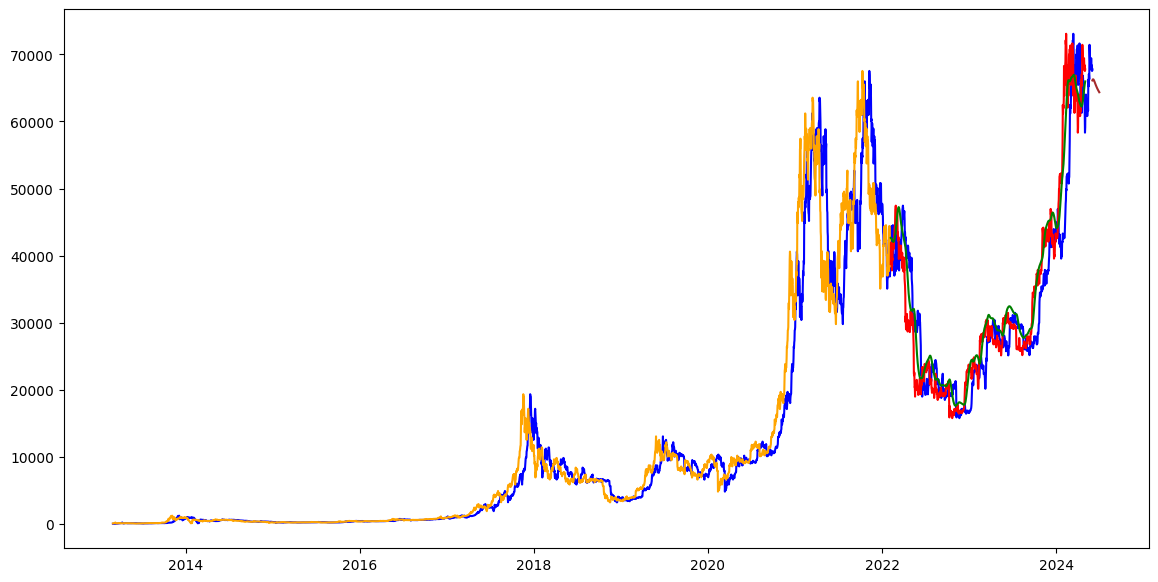

In [127]:
def process_and_plot(df, title):
    data = df['Price'].values.reshape(-1, 1)
    results = []
    for split_ratio in [0.7, 0.8, 0.6]:
        result = process_dataset(df, f'{title} - split {split_ratio}')
        results.append(result)
    return results

bitcoin_results = process_and_plot(bitcoin_df, 'Bitcoin')
nasdaq_results = process_and_plot(nasdaq_df, 'NASDAQ')
usd_results = process_and_plot(usd_df, 'USD')